계획
1. 각 상품별로 다운샘플링 진행
2. Target값을 log변환을 이용해 정규화
3. ARIMA 모델 진행
---
4. 다운샘플링X 각 상품별로 상태로 ARIMA 진행
5. 예측해야할 부분을 전부 합친 다음, d_1450/(d_1450+...d_1456) * 3 번 결과, 이런 식으로 진행

In [70]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

!pip install pyramid-arima
from pyramid.arima import auto_arima

In [0]:
calendar = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/m5-forecasting-accuracy/calendar.csv')
train_date=calendar.loc[:1912,'date']
test_date= calendar.loc[1912:1940,'date']
final_date = calendar.loc[1940:,'date']

# 상품별 다운샘플링 진행
- 28,14,7,X


## BaseLine

In [72]:
CA_sale = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/m5-forecasting-accuracy/CA_sale.pkl')
CA_sale.head()

,id,d,value,wm_yr_wk,sell_price,National,Sporting,Cultural,Religious,LentStart,StPatricksDay,Halloween,Eid al-Fitr,LaborDay,Ramadan starts,NBAFinalsStart,SuperBowl,ValentinesDay,LentWeek2,NBAFinalsEnd,Thanksgiving,Cinco De Mayo,EidAlAdha,Christmas,VeteransDay,OrthodoxChristmas,Purim End,Mother's day,MartinLutherKingDay,PresidentsDay,Easter,NewYear,Father's day,IndependenceDay,Chanukah End,Pesach End,ColumbusDay,MemorialDay,OrthodoxEaster,snap_CA,snap_TX,snap_WI,year,month,wday
0,HOBBIES_1_001_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1
1,HOBBIES_1_002_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1
2,HOBBIES_1_003_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1
3,HOBBIES_1_004_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1
4,HOBBIES_1_005_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1


In [0]:
cap=CA_sale.pivot_table(index='d',columns='id',values='value')

In [74]:
print(cap.shape)
cap.index = train_date
cap.index = pd.to_datetime(cap.index)
cap.head()

(1913, 12196)


id,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_002_CA_1,FOODS_1_002_CA_2,FOODS_1_002_CA_3,FOODS_1_002_CA_4,FOODS_1_003_CA_1,FOODS_1_003_CA_2,FOODS_1_003_CA_3,FOODS_1_003_CA_4,FOODS_1_004_CA_1,FOODS_1_004_CA_2,FOODS_1_004_CA_3,FOODS_1_004_CA_4,FOODS_1_005_CA_1,FOODS_1_005_CA_2,FOODS_1_005_CA_3,FOODS_1_005_CA_4,FOODS_1_006_CA_1,FOODS_1_006_CA_2,FOODS_1_006_CA_3,FOODS_1_006_CA_4,FOODS_1_008_CA_1,FOODS_1_008_CA_2,FOODS_1_008_CA_3,FOODS_1_008_CA_4,FOODS_1_009_CA_1,FOODS_1_009_CA_2,FOODS_1_009_CA_3,FOODS_1_009_CA_4,FOODS_1_010_CA_1,FOODS_1_010_CA_2,FOODS_1_010_CA_3,FOODS_1_010_CA_4,FOODS_1_011_CA_1,FOODS_1_011_CA_2,FOODS_1_011_CA_3,FOODS_1_011_CA_4,...,HOUSEHOLD_2_507_CA_1,HOUSEHOLD_2_507_CA_2,HOUSEHOLD_2_507_CA_3,HOUSEHOLD_2_507_CA_4,HOUSEHOLD_2_508_CA_1,HOUSEHOLD_2_508_CA_2,HOUSEHOLD_2_508_CA_3,HOUSEHOLD_2_508_CA_4,HOUSEHOLD_2_509_CA_1,HOUSEHOLD_2_509_CA_2,HOUSEHOLD_2_509_CA_3,HOUSEHOLD_2_509_CA_4,HOUSEHOLD_2_510_CA_1,HOUSEHOLD_2_510_CA_2,HOUSEHOLD_2_510_CA_3,HOUSEHOLD_2_510_CA_4,HOUSEHOLD_2_511_CA_1,HOUSEHOLD_2_511_CA_2,HOUSEHOLD_2_511_CA_3,HOUSEHOLD_2_511_CA_4,HOUSEHOLD_2_512_CA_1,HOUSEHOLD_2_512_CA_2,HOUSEHOLD_2_512_CA_3,HOUSEHOLD_2_512_CA_4,HOUSEHOLD_2_513_CA_1,HOUSEHOLD_2_513_CA_2,HOUSEHOLD_2_513_CA_3,HOUSEHOLD_2_513_CA_4,HOUSEHOLD_2_514_CA_1,HOUSEHOLD_2_514_CA_2,HOUSEHOLD_2_514_CA_3,HOUSEHOLD_2_514_CA_4,HOUSEHOLD_2_515_CA_1,HOUSEHOLD_2_515_CA_2,HOUSEHOLD_2_515_CA_3,HOUSEHOLD_2_515_CA_4,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,3,2,1,0,0,2,1,0,0,8,1,0,0,0,0,0,3,8,10,2,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,4,5,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2011-01-30,0,0,2,1,1,1,0,1,0,2,1,1,0,0,0,0,9,1,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,4,9,0,0,1,0,0,0,0,0,0,1,1,2,2,0,0,0,0,1,0,1,0
2011-01-31,0,0,1,1,0,1,1,2,0,2,1,0,0,0,0,0,3,1,2,0,3,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,1,1,4,0,0,0,0,0,1,2,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2011-02-01,1,0,1,1,1,0,2,1,0,1,3,0,0,0,0,0,3,0,10,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,1,0,4,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2011-02-02,4,1,1,1,1,2,0,0,1,0,0,1,0,0,0,0,0,5,1,1,7,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,6,1,0,0,0,0,1,0,3,2,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


### 1. 다운샘플링

In [0]:
cap_1wk = cap.resample('14d',label='left').sum()

### 2. 로그변환

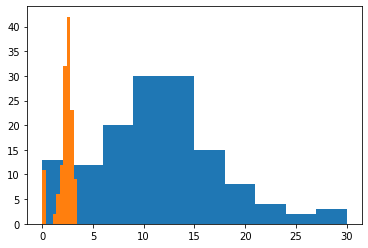

In [122]:
plt.hist(cap_1wk['FOODS_1_001_CA_1'])
plt.hist(np.log1p(cap_1wk['FOODS_1_001_CA_1']))
plt.show()

In [0]:
cap_1wk = np.log1p(cap_1wk)

In [124]:
cap_1wk.head()

id,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_002_CA_1,FOODS_1_002_CA_2,FOODS_1_002_CA_3,FOODS_1_002_CA_4,FOODS_1_003_CA_1,FOODS_1_003_CA_2,FOODS_1_003_CA_3,FOODS_1_003_CA_4,FOODS_1_004_CA_1,FOODS_1_004_CA_2,FOODS_1_004_CA_3,FOODS_1_004_CA_4,FOODS_1_005_CA_1,FOODS_1_005_CA_2,FOODS_1_005_CA_3,FOODS_1_005_CA_4,FOODS_1_006_CA_1,FOODS_1_006_CA_2,FOODS_1_006_CA_3,FOODS_1_006_CA_4,FOODS_1_008_CA_1,FOODS_1_008_CA_2,FOODS_1_008_CA_3,FOODS_1_008_CA_4,FOODS_1_009_CA_1,FOODS_1_009_CA_2,FOODS_1_009_CA_3,FOODS_1_009_CA_4,FOODS_1_010_CA_1,FOODS_1_010_CA_2,FOODS_1_010_CA_3,FOODS_1_010_CA_4,FOODS_1_011_CA_1,FOODS_1_011_CA_2,FOODS_1_011_CA_3,FOODS_1_011_CA_4,...,HOUSEHOLD_2_507_CA_1,HOUSEHOLD_2_507_CA_2,HOUSEHOLD_2_507_CA_3,HOUSEHOLD_2_507_CA_4,HOUSEHOLD_2_508_CA_1,HOUSEHOLD_2_508_CA_2,HOUSEHOLD_2_508_CA_3,HOUSEHOLD_2_508_CA_4,HOUSEHOLD_2_509_CA_1,HOUSEHOLD_2_509_CA_2,HOUSEHOLD_2_509_CA_3,HOUSEHOLD_2_509_CA_4,HOUSEHOLD_2_510_CA_1,HOUSEHOLD_2_510_CA_2,HOUSEHOLD_2_510_CA_3,HOUSEHOLD_2_510_CA_4,HOUSEHOLD_2_511_CA_1,HOUSEHOLD_2_511_CA_2,HOUSEHOLD_2_511_CA_3,HOUSEHOLD_2_511_CA_4,HOUSEHOLD_2_512_CA_1,HOUSEHOLD_2_512_CA_2,HOUSEHOLD_2_512_CA_3,HOUSEHOLD_2_512_CA_4,HOUSEHOLD_2_513_CA_1,HOUSEHOLD_2_513_CA_2,HOUSEHOLD_2_513_CA_3,HOUSEHOLD_2_513_CA_4,HOUSEHOLD_2_514_CA_1,HOUSEHOLD_2_514_CA_2,HOUSEHOLD_2_514_CA_3,HOUSEHOLD_2_514_CA_4,HOUSEHOLD_2_515_CA_1,HOUSEHOLD_2_515_CA_2,HOUSEHOLD_2_515_CA_3,HOUSEHOLD_2_515_CA_4,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,2.833213,3.178054,2.890372,2.197225,2.197225,2.397895,2.079442,1.945910,2.397895,3.218876,2.772589,2.708050,0.0,0.0,0.0,0.0,3.713572,4.127134,4.394449,2.484907,3.737670,3.465736,3.218876,3.433987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.484907,0.000000,2.833213,1.945910,...,1.098612,1.098612,1.609438,1.609438,0.0,0.0,0.0,0.0,2.708050,2.079442,3.465736,0.693147,0.0,0.0,0.0,0.0,3.526361,3.295837,4.189655,2.484907,1.945910,2.564949,1.098612,0.000000,0.0,0.0,0.0,0.0,2.302585,2.197225,1.791759,1.945910,0.0,0.0,0.0,0.0,2.079442,0.693147,1.609438,0.000000
2011-02-12,3.178054,3.610918,3.178054,2.197225,0.693147,2.890372,1.098612,1.386294,2.772589,3.332205,3.178054,2.397895,0.0,0.0,0.0,0.0,3.737670,4.718499,4.077538,2.708050,3.912023,3.091043,3.091043,3.496508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.397895,0.000000,2.302585,2.639057,...,2.484907,3.433987,3.178054,2.564949,0.0,0.0,0.0,0.0,2.890372,2.639057,3.091043,1.098612,0.0,0.0,0.0,0.0,3.713572,3.044523,3.970292,2.079442,2.079442,2.944439,3.044523,0.000000,0.0,0.0,0.0,0.0,1.945910,2.079442,1.609438,0.693147,0.0,0.0,0.0,0.0,1.098612,0.693147,1.945910,0.693147
2011-02-26,3.295837,2.302585,3.637586,2.564949,2.197225,2.639057,1.609438,1.945910,2.564949,3.091043,3.135494,2.484907,0.0,0.0,0.0,0.0,2.995732,4.691348,3.688879,2.639057,4.077538,3.367296,1.386294,3.178054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438,0.000000,2.772589,1.791759,...,2.484907,3.295837,3.218876,1.098612,0.0,0.0,0.0,0.0,2.484907,2.484907,3.332205,0.693147,0.0,0.0,0.0,0.0,3.433987,3.332205,4.127134,2.484907,1.386294,3.218876,3.044523,1.791759,0.0,0.0,0.0,0.0,0.000000,0.000000,0.693147,1.098612,0.0,0.0,0.0,0.0,0.000000,0.693147,0.693147,0.000000
2011-03-12,2.639057,3.044523,2.708050,2.397895,1.609438,2.302585,1.945910,1.945910,2.564949,3.295837,2.833213,1.945910,0.0,0.0,0.0,0.0,3.295837,4.430817,3.912023,2.302585,3.258096,3.688879,0.000000,2.995732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.079442,0.000000,3.295837,2.484907,...,2.302585,3.178054,2.484907,2.397895,0.0,0.0,0.0,0.0,2.708050,2.397895,2.995732,0.693147,0.0,0.0,0.0,0.0,3.135494,3.526361,3.433987,2.197225,2.397895,2.397895,2.397895,2.302585,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.098612,1.609438,1.609438,0.000000
2011-03-26,2.484907,2.564949,3.332205,2.197225,1.945910,2.772589,1.791759,1.386294,2.48

### 3. ARIMA 모델 진행

train, val split

In [0]:
train=cap_1wk.iloc[:-6]
val=cap_1wk.iloc[-6:]

In [142]:
train['FOODS_1_001_CA_1']

date
2011-01-29    2.833213
2011-02-12    3.178054
2011-02-26    3.295837
2011-03-12    2.639057
2011-03-26    2.484907
                ...   
2015-11-28    2.708050
2015-12-12    2.397895
2015-12-26    2.079442
2016-01-09    1.609438
2016-01-23    2.639057
Freq: 14D, Name: FOODS_1_001_CA_1, Length: 131, dtype: float32

In [143]:
stepwise_model = auto_arima(train['FOODS_1_001_CA_1'], start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=243.005, BIC=256.858, Fit time=1.875 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=308.928, BIC=314.469, Fit time=0.108 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=272.422, BIC=283.504, Fit time=0.471 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=242.663, BIC=253.746, Fit time=1.486 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=243.983, BIC=257.837, Fit time=2.973 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=306.354, BIC=314.666, Fit time=0.082 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=243.789, BIC=257.642, Fit time=3.041 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=246.334, BIC=262.958, Fit time=5.707 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=245.317, BIC=253.629, Fit time=0.894 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 

In [144]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  131
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -117.331
Date:                            Wed, 10 Jun 2020   AIC                            242.663
Time:                                    11:05:22   BIC                            253.746
Sample:                                         0   HQIC                           247.163
                                            - 131                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0031      0.013      0.234      0.815      -0.023       0.029
ma.L1         -0.1991      0.091     -2.186      0.029      -0.378      -0.021
ma.S.L12      -0.9977     11.040     -0.090      0.928     -22.636      20.641
sigma2         0.3365      3.703      0.091      0.928      -6.922       7.595
===================================================================================
Ljung-Box (Q):                       32.23   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.80   Prob(JB):                         0.92
Heteroskedasticity (H):               0.93   Skew:                             0.07
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [145]:
stepwise_model.fit(train['FOODS_1_001_CA_1'])

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

In [146]:
future_forecast = stepwise_model.predict(n_periods=val['FOODS_1_001_CA_1'].shape[0])
print(future_forecast)

[2.47543584 2.11663664 2.12565312 2.17806543 1.97084661 2.09060704]


In [0]:
future_forecast = pd.DataFrame(future_forecast,
                               index = val['FOODS_1_001_CA_1'].index,
                               columns=['Prediction'])

In [148]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_forecast.index, y=future_forecast['Prediction'], showlegend=True,
                         mode='lines', name="Prediction",
                         marker=dict(color="blue")))
fig.add_trace(go.Scatter(x=val['FOODS_1_001_CA_1'].index, y= val['FOODS_1_001_CA_1'], showlegend=True,
                         mode='lines', name="Test",
                         marker=dict(color="red")))
fig.update_layout(height=400, width=600)
fig.show()

다운샘플링을 2주로 잡고하니까 꽤 비슷하게 나오는 것 같음.